In [ ]:
#####Version 3, this time we are going to attempt to build a neural net to tackle our problem, after the failure of SGD :(
#####We will still include the baseline model for reference
!pip install -Uqq fastbook
from fastbook import *
from fastai.vision.all import *
matplotlib.rc("image", cmap="Greys")

In [ ]:
from google.colab import drive
#mount content from my drive
drive.mount("/content/josh_drive")

Mounted at /content/josh_drive


In [ ]:
import zipfile
import os
import shutil
#unzip data in tmp folder
f_path = Path("/content/josh_drive/MyDrive/Colab Notebooks/My experiments/COVID-19_Radiography_Database.zip")
zip_file = zipfile.ZipFile(f_path, "r")
zip_file.extractall("/tmp")
zip_file.close()

In [ ]:
#set image path
image_path = Path("/tmp/COVID-19_Radiography_Dataset/")
#print total number images
all_images = get_image_files(image_path)
print(len(all_images))

21165


In [ ]:
#make directories for sample dataset with just COVID and normal images
os.mkdir(image_path/"Sample")
s_image_path = image_path/"Sample"
os.mkdir(s_image_path/"Normal"), os.mkdir(s_image_path/"Normal"/"Train"), os.mkdir(s_image_path/"Normal"/"Valid")
os.mkdir(s_image_path/"COVID"), os.mkdir(s_image_path/"COVID"/"Train"), os.mkdir(s_image_path/"COVID"/"Valid")
Normal_images, COVID_images = get_image_files(image_path/"Normal"), get_image_files(image_path/"COVID")
print(len(Normal_images), " ||| ", len(COVID_images))

10192  |||  3616


In [ ]:
#move images to create sample dataset with train and valid sets
sample_pct = 0.1
random.seed(0)
normal_sample = random.sample(Normal_images, int(len(Normal_images) * sample_pct))
covid_sample = random.sample(COVID_images, len(normal_sample)) #this number gives a balanced dataset
#initially move all sample images to train folder
for normal_img in normal_sample:
    shutil.copy(normal_img, s_image_path/"Normal"/"Train"/normal_img.name)
for covid_img in covid_sample:
    shutil.copy(covid_img, s_image_path/"COVID"/"Train"/covid_img.name)
normal_sample, covid_sample = get_image_files(s_image_path/"Normal"/"Train"), get_image_files(s_image_path/"COVID"/"Train")

In [ ]:
#then sample from train folder to get validation set
valid_pct = 0.2
normal_valid = random.sample(normal_sample, int(len(normal_sample) * valid_pct))
covid_valid = random.sample(covid_sample, int(len(covid_sample) * valid_pct))
for valid_normal_img in normal_valid:
    shutil.move(valid_normal_img, s_image_path/"Normal"/"Valid"/valid_normal_img.name)
    #valid_normal_img.rename(s_image_path/"Normal"/"Valid"/valid_normal_img.name)
for valid_covid_img in covid_valid:
    shutil.move(valid_covid_img, s_image_path/"COVID"/"Valid"/valid_covid_img.name)
    #valid_covid_img.rename(s_image_path/"COVID"/"Valid"/valid_covid_img.name)

In [ ]:
normal_train, normal_valid = get_image_files(s_image_path/"Normal"/"Train"), get_image_files(s_image_path/"Normal"/"Valid")
covid_train, covid_valid = get_image_files(s_image_path/"COVID"/"Train"), get_image_files(s_image_path/"COVID"/"Valid")
print("Normal train and valid: ", len(normal_train), " ||| ", len(normal_valid))
print("COVID train and valid: ", len(covid_train), " ||| ", len(covid_valid))

Normal train and valid:  408  |||  101
COVID train and valid:  408  |||  101


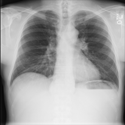

In [ ]:
test_image = Image.open(normal_train[0])
test_image.to_thumb(125,125)

In [ ]:
#create lists of opened images stored as tensors
normal_train_tensors = [tensor(Image.open(img)) for img in normal_train]
normal_valid_tensors = [tensor(Image.open(img)) for img in normal_valid]
covid_train_tensors = [tensor(Image.open(img)) for img in covid_train]
covid_valid_tensors = [tensor(Image.open(img)) for img in covid_valid]
#stack these tensors into singular 3 dim tensors
stacked_normal_train  = torch.stack(normal_train_tensors).float()/255
stacked_normal_valid = torch.stack(normal_valid_tensors).float()/255
stacked_covid_train = torch.stack(covid_train_tensors).float()/255
stacked_covid_valid = torch.stack(covid_valid_tensors).float()/255
print(stacked_normal_train.shape, stacked_normal_valid.shape)

torch.Size([408, 299, 299]) torch.Size([101, 299, 299])


torch.Size([299, 299])


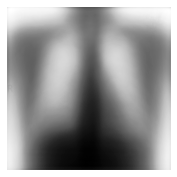

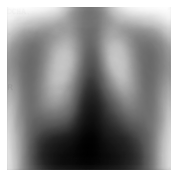

In [ ]:
###Baseline "pixel similarity" model using average pixel values
#calculate mean of normal/covid images by taking mean over dimension 0 of our stack, this gives us a 2d tensor of averages for each pixel
mean_normal_train = stacked_normal_train.mean(0)
mean_covid_train = stacked_covid_train.mean(0)
show_image(mean_normal_train, figsize=(3,3)) #special fastai function for showing images from tensors
show_image(mean_covid_train, figsize=(3,3))
print(mean_normal_train.shape)

In [ ]:
#if an image is closer to mean covid image it is covid, if not it is normal
#how close an image is defined by L1 norm (mean absolute error). Average of the difference to the mean image at each pixel value
def L1_norm(a, b):
    return (a-b).abs().mean((-1,-2)) #take mean ranging over values indexed by last two axis of tensor(horizontal/vertical image dimensions)
def Is_COVID(tnsor):
    return L1_norm(tnsor, mean_normal_train) > L1_norm(tnsor, mean_covid_train)
L1_norm(stacked_normal_train[0], mean_normal_train), L1_norm(stacked_normal_train[0], mean_covid_train), Is_COVID(stacked_normal_train[0])

(tensor(0.1756), tensor(0.1682), tensor(True))

In [ ]:
#due to casting we can apply Is_COVID to many tensors at once and calculate the accuracy (our chosen metric) of our baseline model
inv_accuracy_Normal = Is_COVID(stacked_normal_valid).float().mean()
accuracy_COVID = Is_COVID(stacked_covid_valid).float().mean()
correct = torch.unique(Is_COVID(stacked_normal_valid), return_counts=True)[1][0]
correct += torch.unique(Is_COVID(stacked_covid_valid), return_counts=True)[1][1]
base_accuracy = correct / (stacked_normal_valid.shape[0] + stacked_covid_valid.shape[0])
print(f"Normal accuracy: {1 - inv_accuracy_Normal}      COVID accuracy: {accuracy_COVID}")
print("Overall accuracy: ", base_accuracy.item()) #.item() can convert a 1 element tensor to just its value

Normal accuracy: 0.7623762488365173      COVID accuracy: 0.6732673048973083
Overall accuracy:  0.7178217768669128


In [ ]:
###Neural net
#place images into single tensor, also convert images to 1D arrays for simplicity
#view changes tensor shape but not data, -1 argument infers the size of that dimension from 299*299 to give 552 vectors
img_dims = (stacked_normal_train[0].shape[0], stacked_normal_train[0].shape[1])
train_x = torch.cat([stacked_normal_train, stacked_covid_train]).view(-1, img_dims[0]*img_dims[1])
valid_x = torch.cat([stacked_normal_valid, stacked_covid_valid]).view(-1, img_dims[0]*img_dims[1])
print(stacked_normal_train.shape, stacked_covid_train.shape, train_x.shape, valid_x.shape)

torch.Size([408, 299, 299]) torch.Size([408, 299, 299]) torch.Size([816, 89401]) torch.Size([202, 89401])


In [ ]:
train_y = tensor([0]*len(stacked_normal_train) + [1]*len(stacked_covid_train))
valid_y = tensor([0]*len(stacked_normal_valid) + [1]*len(stacked_covid_valid))
print(train_y.shape, valid_y.shape)
#train_y = train_y.unsqueeze(1) #unsqueeze changes shape from [816]->[816, 1] (vector to single column), needed for valid matrix multiplication
#print(train_y.shape)

torch.Size([816]) torch.Size([202])


In [ ]:
#create a dataset
train_dataset = list(zip(train_x, train_y))
valid_dataset = list(zip(valid_x, valid_y))
x,y = train_dataset[0]
len(train_dataset), x.shape, y    #each entry in dataset contains an image and a label

(816, torch.Size([89401]), tensor(0))

In [ ]:
#create dataloaders for shuffling and minibatch collation from the dataset
set_seed(0, reproducible=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=True)
x,y = first(train_dataloader) #first used as dataloaders used for iterating not random access (so have no __getitem__ method)
len(train_dataloader), x.shape, y.shape #first element of dataloader contains 64 images and 64 corresponding labels, taken randomly

(13, torch.Size([64, 89401]), torch.Size([64]))